# Continuous Bernoulli 

In [64]:
# Libraries 
import os
import torch
import argparse
import torchvision
import numpy as np
from glob import glob
import torch.utils.data
from torch import nn, optim
import matplotlib.pyplot as plt
from torch.nn import functional as F
from torchvision.utils import save_image
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

%matplotlib inline

#Set reproducibility seeed
torch.manual_seed(1)

## Load and Preprocess MNIST Dataset 

In [66]:
# Load test data
BATCH_SIZE = 128

## MNIST Preprocessing as described in Appendix 4

# Add custom transofrmation that adds uniform [0,1] noise 
# to the integer pixel values between 0 and 255 and then 
# divide by 256, to obtain values in [0,1]

        
class AddNoiseToTensor(object):

    def __call__(self, pic):
        
        img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
        nchannel = len(pic.mode)
        img = img.view(pic.size[1], pic.size[0], nchannel)
        img = img.transpose(0, 1).transpose(0, 2).contiguous()
        tensor = img.float()
        return ( tensor + torch.rand(tensor.size())).div(256)

## MNIST
mnist_train_loader = torch.utils.data.DataLoader(
                            datasets.MNIST('../../data', train=True, download=True,
                            transform = AddNoiseToTensor()),
                            batch_size = BATCH_SIZE, shuffle = True)

mnist_test_loader = torch.utils.data.DataLoader(
                            datasets.MNIST('../../data', train=False, 
                            transform = AddNoiseToTensor()),
                            batch_size = BATCH_SIZE, shuffle = True)

    9     3     0     1     2     4     6     8     1     1     2     3     0     7     0     0


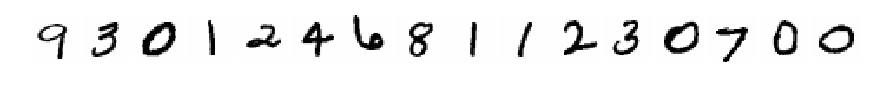

In [67]:
# Visualize dataset 
dataiter = iter(mnist_train_loader)
mnist_images, mnist_labels = dataiter.next()

def imshow(img):
    npimg = 1 - img.numpy() # White background
    plt.figure(figsize = (15, 15))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)), 
               interpolation = 'nearest')

# Display images with labels
imshow(torchvision.utils.make_grid(mnist_images[:16], 16 ))
print(' '.join('%5s' % str(mnist_labels[j].item()) for j in range(16)))

## Variational Autoencoder

In [59]:
# VAE model 

## Architectured Based on Appendix by Authors
## https://arxiv.org/src/1907.06845v4/anc/cont_bern_aux.pdf

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        # Encoder layers
        self.fc1 = nn.Linear(784, 500)
        self.fc2 = nn.Linear(500, 500)
        self.fc21 = nn.Linear(500, 20)
        self.fc22 = nn.Linear(500, 20)
        
        # Decoder layers
        self.fc3 = nn.Linear(20, 500)
        self.fc4 = nn.Linear(500, 500)
        self.fc5 = nn.Linear(500, 784)
        
        # Dropout Layers
        self.dropout1 = nn.Dropout(0.9)
        self.dropout2 = nn.Dropout(0.9)
        self.dropout3 = nn.Dropout(0.9)
        self.dropout4 = nn.Dropout(0.9)

    def encode(self, x):
        #Recognition function
        h1 = F.relu(self.fc1(x))
        h1 = self.dropout1(h1)
        h2 = F.relu(self.fc2(h1))
        h2 = self.dropout2(h2)
        return self.fc21(h2), self.fc22(h2) # Change to softplus

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        #Likelihood function
        h3 = F.relu(self.fc3(z))
        h3 = self.dropout3(h3)
        h4 = F.relu(self.fc4(h3))
        h4 = self.dropout4(h4)
        return torch.sigmoid(self.fc5(h4)) # Gaussian mean

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
    
# Loss function
def loss_vae(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

## Train VAE on MNIST

In [60]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train(epochs, train_loader, 
          loss_function, log_interval = 1000):
    
    model.train()
    for epoch in range(1, epochs + 1):
        train_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader),
                    loss.item() / len(data)))

        print('====> Epoch: {} Average loss: {:.4f}'.format(
              epoch, train_loss / len(train_loader.dataset)))


In [61]:
# Train model
train(10, mnist_train_loader, loss_vae)

Train Epoch: 1 [0/60000 (0%)]	Loss: 646.831116
====> Epoch: 1 Average loss: 232.5695
Train Epoch: 2 [0/60000 (0%)]	Loss: 216.724823
====> Epoch: 2 Average loss: 216.7235
Train Epoch: 3 [0/60000 (0%)]	Loss: 211.829880
====> Epoch: 3 Average loss: 214.8263
Train Epoch: 4 [0/60000 (0%)]	Loss: 211.412598
====> Epoch: 4 Average loss: 212.6956
Train Epoch: 5 [0/60000 (0%)]	Loss: 218.188766
====> Epoch: 5 Average loss: 211.2975
Train Epoch: 6 [0/60000 (0%)]	Loss: 214.778763
====> Epoch: 6 Average loss: 210.4397
Train Epoch: 7 [0/60000 (0%)]	Loss: 211.601074
====> Epoch: 7 Average loss: 209.7903
Train Epoch: 8 [0/60000 (0%)]	Loss: 205.392151
====> Epoch: 8 Average loss: 209.2105
Train Epoch: 9 [0/60000 (0%)]	Loss: 207.178085
====> Epoch: 9 Average loss: 208.4735
Train Epoch: 10 [0/60000 (0%)]	Loss: 210.374695
====> Epoch: 10 Average loss: 207.3871


In [63]:
## Generate samples from trained model
with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = model.decode(sample).cpu()
        #imshow(torchvision.utils.make_grid(sample[:16], 16 ))
        save_image(sample.view(64, 1, 28, 28),
                   'sample_' + str(10) + '.png')

## Continuous Bernoulli VAE

In [262]:
def C( x ):
    return (2. * np.arctanh(1. - 2.*x))/(1. - 2.*x) 
    
def logC( x ):
    # Numerically stable implementation
    if abs(x - 0.5) < 1e-3:
        # Taylor Approximation around 0.5
        value = np.log(2.)
        taylor = 1; nu = 1. - 2. * x; e = 1; k = nu**2
        for i in range(1, 10): 
            e *= k; taylor += e / (2. * i + 1) 
        return value + np.log( taylor )
    return np.log( C(x) )

In [270]:
# Testing numerical inestability
l = 0.499
print('At lambda = 0.499:')
print( logC(l))
print( np.log(C(l)))

l = 0.5-1e-17
print('\n At lambda ~ 0.5:')
print( logC(l))
print( np.log(C(l)) ) 

At lambda = 0.499:
0.6931485138955896
0.6931485138955896

 At lambda ~ 0.5:
0.6931471805599453
nan


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


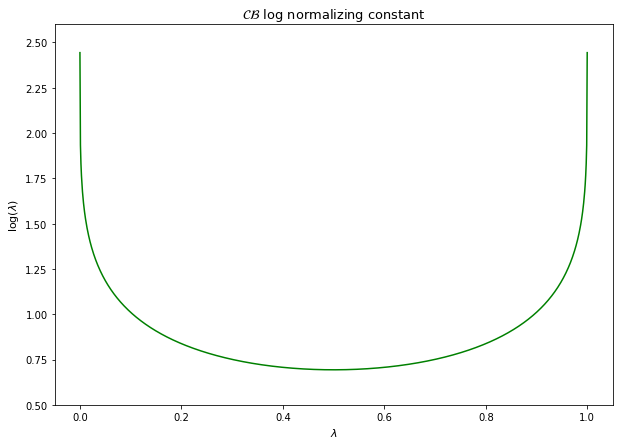

In [351]:
# Plot Continuous Bernoulli Log Normalizing Constant 
x = np.linspace(0.00001,0.99999,1000)
y = [ logC(i) for i in x ]

plt.figure(figsize = (10, 7))
plt.title('$\mathcal{C}\mathcal{B}$ log normalizing constant', 
           fontsize = 13)
plt.ylim(0.50, 2.6)
plt.plot(x, y, color = 'green' , label = 'Taylor Approximation') 
plt.ylabel('$\log(\lambda)$', fontsize = 11)
plt.xlabel('$\lambda$', fontsize = 11)
plt.show()

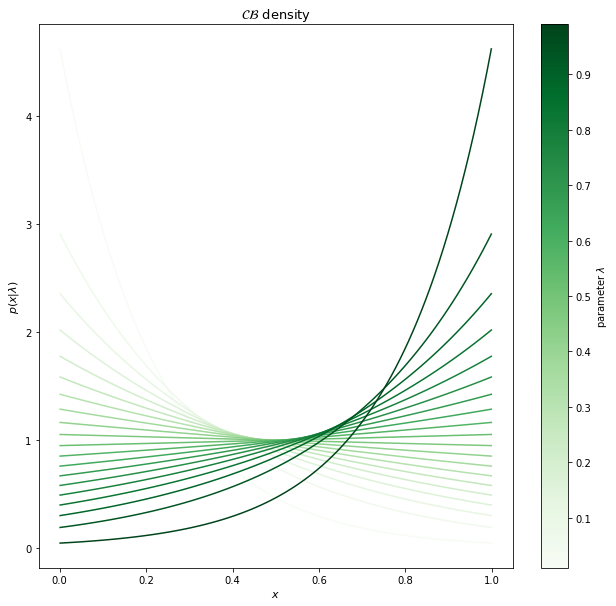

In [350]:
from matplotlib import cm as color_map
import matplotlib as mpl
    
x = np.linspace(0.001,0.999,100)
l = np.linspace(0.01,0.99,20)

y = np.asarray( [ [ np.exp(logC(i))*np.power(i,j)*np.power(1-i,1-j) for j in x] for i in l] )

plt.figure(figsize = (10, 10))

number_of_plots = len(l)
color_map_name = 'Greens'
my_map = color_map.get_cmap(color_map_name)
colors = my_map(np.linspace(0, 1, number_of_plots, endpoint=True))

norm = mpl.colors.Normalize(vmin=l[0], vmax=l[-1])
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=color_map_name)
cmap.set_array([])

for i in range(len(l)):
    plt.plot(x, y[i,:], color = colors[i]) 

plt.title('$\mathcal{C}\mathcal{B}$ density', 
           fontsize = 13)

plt.ylabel('$p(x |\lambda)$', fontsize = 11)
plt.xlabel('$x$', fontsize = 11)

plt.colorbar(cmap, ticks=np.linspace(0, 1, 11), 
             shrink=1.0, fraction=0.1, pad=0.05 , label = 'parameter $\lambda$')
plt.show()